In [1]:
import sys
sys.path.append('../') 
from imports import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import ParameterGrid
import concurrent.futures



In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
torch.cuda.is_available()

True

In [4]:
# Load the saved datasets
train_data = np.load('./fashion-mnist-processed-data/train_data.npy')
val_data = np.load('./fashion-mnist-processed-data/val_data.npy')
test_data = np.load('./fashion-mnist-processed-data/test_data.npy')

train_targets = np.load('./fashion-mnist-processed-data/train_targets.npy')
val_targets = np.load('./fashion-mnist-processed-data/val_targets.npy')
test_targets = np.load('./fashion-mnist-processed-data/test_targets.npy')

In [5]:
train_data = np.expand_dims(train_data, axis=1)
val_data = np.expand_dims(val_data, axis=1)
test_data = np.expand_dims(test_data, axis=1)


In [6]:
# Converting to tensors
train_data, train_targets = torch.tensor(train_data, dtype=torch.float32), torch.tensor(train_targets, dtype=torch.long)
val_data, val_targets = torch.tensor(val_data, dtype=torch.float32), torch.tensor(val_targets, dtype=torch.long)
test_data, test_targets = torch.tensor(test_data, dtype=torch.float32), torch.tensor(test_targets, dtype=torch.long)


In [7]:
# Normalizeing the data
train_data = train_data/ 255.0
val_data = val_data/255.0
test_data = test_data/255.0

In [8]:
# Data loaders and set batch size for training, validation, testing
batch_size = 64
train_loader = DataLoader(TensorDataset(train_data, train_targets), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_data, val_targets), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(test_data, test_targets), batch_size=batch_size, shuffle=False)


In [9]:
#Single layer CNN model
class SingleLayerCNN(nn.Module):
    def __init__(self):
        super(SingleLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(32 * 28 * 28, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [12]:

model = SingleLayerCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [13]:
# Training and validation for certain epochs
epochs = 10
for epoch in range(epochs):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        total_train = 0
        correct_train = 0
    
        for images_train, labels_train in train_loader:
            images_train, labels_train = images_train.to(device), labels_train.to(device)
            outputs_train = model(images_train)
            _, predicted_train = torch.max(outputs_train.data, 1)
            total_train += labels_train.size(0)
            correct_train += (predicted_train == labels_train).sum().item()
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        train_accuracy = 100 * correct_train / total_train
        val_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{epochs}], Training accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')


Epoch [1/10], Training accuracy: 89.52%, Validation Accuracy: 88.15%
Epoch [2/10], Training accuracy: 91.62%, Validation Accuracy: 89.35%
Epoch [3/10], Training accuracy: 92.96%, Validation Accuracy: 90.10%
Epoch [4/10], Training accuracy: 93.74%, Validation Accuracy: 90.53%
Epoch [5/10], Training accuracy: 93.81%, Validation Accuracy: 90.10%
Epoch [6/10], Training accuracy: 94.17%, Validation Accuracy: 90.13%
Epoch [7/10], Training accuracy: 95.34%, Validation Accuracy: 90.33%
Epoch [8/10], Training accuracy: 95.08%, Validation Accuracy: 90.17%
Epoch [9/10], Training accuracy: 96.20%, Validation Accuracy: 90.45%
Epoch [10/10], Training accuracy: 95.92%, Validation Accuracy: 90.38%


In [14]:
# Prediction on a single item from test set
model.eval()
with torch.no_grad():
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    print(f'Predicted label: {predicted[0].item()}, Actual label: {labels[0].item()}')

Predicted label: 9, Actual label: 9


In [15]:
# Evaluation on test data
model.eval()
with torch.no_grad():
    correct_test = 0
    total_test = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 89.85%


In [26]:
# Now let us perform hyperparamter tuning to find optimal parameters and replace them where needed!
# Defining the parametr grid for hyperparameter tuning
param_grid = {
    'lr': [0.001, 0.01],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

In [27]:
# Function to train and evaluate the model
def train_val_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs=3):
    
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    return val_accuracy

In [28]:
# Let us begin Hyperparameter tuning
best_accuracy = 0
best_params = None

for params in ParameterGrid(param_grid):
    # Update batch size for data loaders
    train_loader = DataLoader(TensorDataset(train_data, train_targets), batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(TensorDataset(val_data, val_targets), batch_size=params['batch_size'], shuffle=False)
    model = SingleLayerCNN().to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])

    # Training and evaluating the model
    accuracy = train_val_evaluate(model, train_loader, val_loader, criterion, optimizer, params['epochs'])
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

    print(f"Params: {params}, Validation Accuracy: {accuracy:.2f}%")

print(f"Best Params: {best_params}, Best Accuracy: {best_accuracy:.2f}%")

Params: {'batch_size': 32, 'epochs': 50, 'lr': 0.001}, Validation Accuracy: 89.57%
Params: {'batch_size': 32, 'epochs': 50, 'lr': 0.01}, Validation Accuracy: 85.95%
Params: {'batch_size': 32, 'epochs': 100, 'lr': 0.001}, Validation Accuracy: 89.33%
Params: {'batch_size': 32, 'epochs': 100, 'lr': 0.01}, Validation Accuracy: 85.05%
Params: {'batch_size': 64, 'epochs': 50, 'lr': 0.001}, Validation Accuracy: 89.43%
Params: {'batch_size': 64, 'epochs': 50, 'lr': 0.01}, Validation Accuracy: 86.43%
Params: {'batch_size': 64, 'epochs': 100, 'lr': 0.001}, Validation Accuracy: 89.75%
Params: {'batch_size': 64, 'epochs': 100, 'lr': 0.01}, Validation Accuracy: 86.27%
Best Params: {'batch_size': 64, 'epochs': 100, 'lr': 0.001}, Best Accuracy: 89.75%


In [33]:

model = SingleLayerCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Epoch [1/100], Training accuracy: 93.53%, Validation Accuracy: 90.28%
Epoch [2/100], Training accuracy: 94.20%, Validation Accuracy: 90.03%
Epoch [3/100], Training accuracy: 94.68%, Validation Accuracy: 90.53%
Epoch [4/100], Training accuracy: 95.13%, Validation Accuracy: 90.32%
Epoch [5/100], Training accuracy: 95.55%, Validation Accuracy: 90.68%
Epoch [6/100], Training accuracy: 95.84%, Validation Accuracy: 90.87%
Epoch [7/100], Training accuracy: 96.30%, Validation Accuracy: 90.37%
Epoch [8/100], Training accuracy: 96.43%, Validation Accuracy: 90.28%
Epoch [9/100], Training accuracy: 96.80%, Validation Accuracy: 90.27%
Epoch [10/100], Training accuracy: 97.04%, Validation Accuracy: 90.08%
Epoch [11/100], Training accuracy: 97.27%, Validation Accuracy: 90.55%
Epoch [12/100], Training accuracy: 97.41%, Validation Accuracy: 90.28%
Epoch [13/100], Training accuracy: 97.69%, Validation Accuracy: 90.25%
Epoch [14/100], Training accuracy: 97.73%, Validation Accuracy: 90.15%
Epoch [15/100],

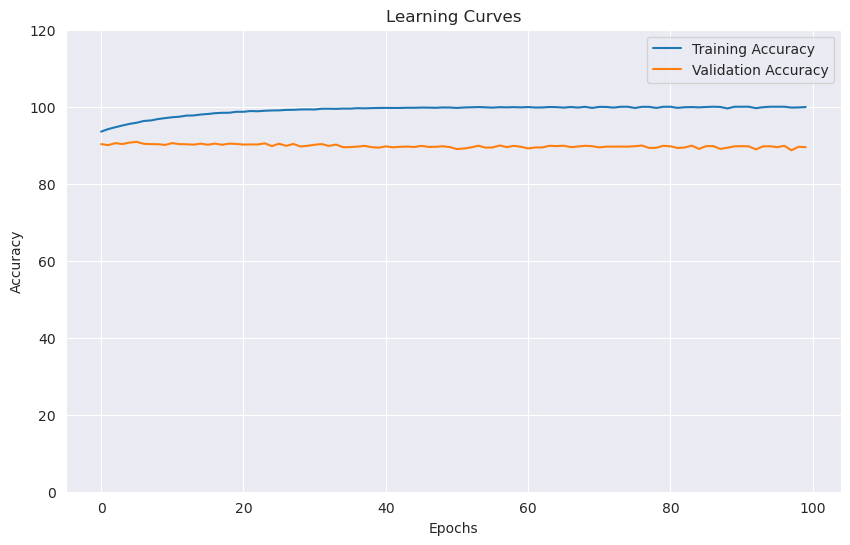

In [10]:
#Single layer CNN model
class SingleLayerCNN(nn.Module):
    def __init__(self):
        super(SingleLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(32 * 28 * 28, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


model = SingleLayerCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists for accuracies and losses
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

epochs = 100
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    total_train = 0
    correct_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')




Epoch [1/100], Training Loss: 0.4401, Training Accuracy: 84.33%, Validation Loss: 0.3282, Validation Accuracy: 88.73%
Epoch [2/100], Training Loss: 0.2890, Training Accuracy: 89.58%, Validation Loss: 0.3111, Validation Accuracy: 88.88%
Epoch [3/100], Training Loss: 0.2509, Training Accuracy: 91.03%, Validation Loss: 0.2926, Validation Accuracy: 89.80%
Epoch [4/100], Training Loss: 0.2253, Training Accuracy: 91.81%, Validation Loss: 0.2934, Validation Accuracy: 89.93%
Epoch [5/100], Training Loss: 0.2053, Training Accuracy: 92.63%, Validation Loss: 0.2907, Validation Accuracy: 90.38%
Epoch [6/100], Training Loss: 0.1864, Training Accuracy: 93.33%, Validation Loss: 0.2854, Validation Accuracy: 90.23%
Epoch [7/100], Training Loss: 0.1700, Training Accuracy: 93.98%, Validation Loss: 0.2804, Validation Accuracy: 90.70%
Epoch [8/100], Training Loss: 0.1566, Training Accuracy: 94.33%, Validation Loss: 0.2933, Validation Accuracy: 90.33%
Epoch [9/100], Training Loss: 0.1448, Training Accuracy:

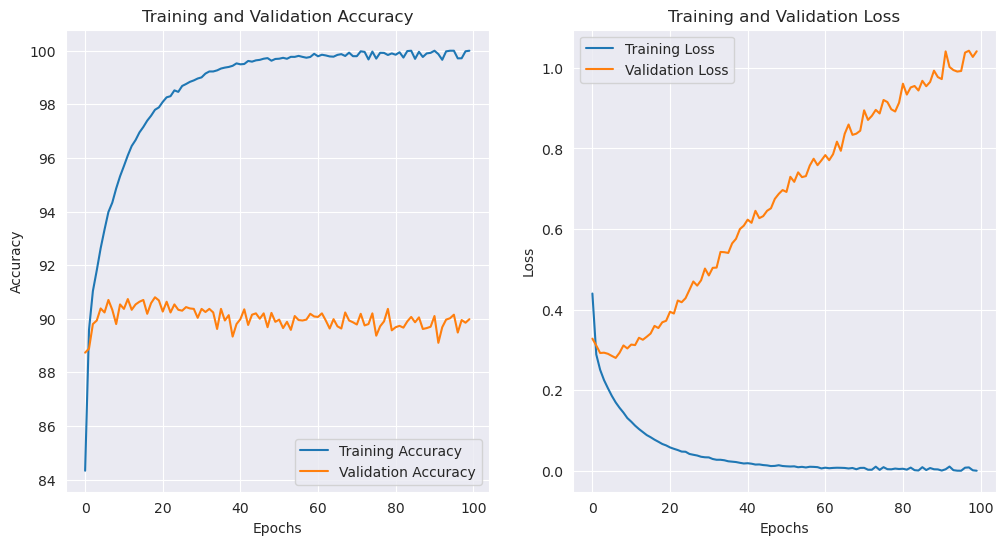

In [11]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plotting the learning curves for loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()